In [243]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from os import path
import librosa
import librosa.display
from sklearn.model_selection import train_test_split

import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing

import cv2

In [279]:
def resize_all(images_2d, wanted_shape):
    res_images = []
    for image in images_2d:
        resized = cv2.resize(image[0], dsize=wanted_shape)
        #print(resized.shape)
        res_images.append([resized])
    return res_images

def normalize_and_pca(images_2d, variance, normalize_only=False, pca_only=False):
    orig_x = images_2d[0][0].shape[0]
    orig_y = images_2d[0][0].shape[1]
    image_length = orig_x * orig_y
    images_1d = []
    
    for image in images_2d:
        images_1d.append(image[0].reshape((image_length)))
    
    data_encoded = images_1d
    
    # normalize
    if not pca_only:
        data_encoded = preprocessing.normalize(data_encoded)

        if normalize_only:
            images_2d = []
            for i in range(len(data_encoded)):
                images_2d.append([data_encoded[i].reshape(orig_x, orig_y)])
            return images_2d
    
    # pca
    pca = PCA(n_components=variance) # Used instead of k to compute minimum number of dimensions to preserve % of variance
    X_reduced = pca.fit(data_encoded).transform(data_encoded)
    X_recovered = pca.inverse_transform(X_reduced)
    
    images_2d = []
    for i in range(len(X_recovered)):
        images_2d.append([X_recovered[i].reshape(orig_x, orig_y)])
    return images_2d
    
def mel_spect(filepath):
    y, sr = librosa.load(filepath)
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    #librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time');
    return mel_spect

## GTZAN

In [264]:
X = []
labels = []
dir_name = 'raw_data/gtzan/genres/'
for path in Path(dir_name).rglob('*.wav'):
    x = mel_spect(path)

    y_padding = 660 - x.shape[1]
    d = np.zeros((128, y_padding))
    x = np.hstack((x, d))

    print(x.shape)
    assert(x.shape == (128, 660))

    X.append(np.array([x]))
    labels.append(path.name.split('.')[0])

# Y to int label
Y = []
unique_labels = list(np.unique(labels))
for i, y in enumerate(labels):
    Y.append(unique_labels.index(y))

(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)

(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)
(128, 660)

In [265]:
print(np.unique(labels))

['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


In [280]:
X_resized = resize_all(X, (165, 32))

In [281]:
#X_pca = normalize_and_pca(np.array(X), variance=0.3)

In [282]:
X_train, X_test, y_train, y_test = train_test_split(X_resized, Y, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))

train = []
for i in range(len(X_train)):
    sample = (X_train[i], y_train[i])
    train.append(sample)
    
test = []
for i in range(len(X_test)):
    sample = (X_test[i], y_test[i])
    test.append(sample)

800
200


In [278]:
pickle.dump(train, open('data/GTZAN_resized.train', 'wb'))
pickle.dump(test, open('data/GTZAN_resized.test', 'wb'))

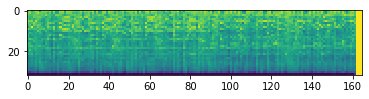

In [283]:
plt.imshow(train[50][0][0], interpolation='nearest')
plt.show()

## FMA

In [238]:
X = []
labels = []
dir_name = 'raw_data/fma/fma_medium'

try:
    for path in Path(dir_name).rglob('*.wav'):
        print(path)
        try:
            x = mel_spect(path)

            y_padding = 660 - x.shape[1]
            d = np.zeros((128, y_padding))
            x = np.hstack((x, d))

            #print(x.shape)
            assert(x.shape == (128, 660))

            X.append(np.array([x]))
            labels.append(path.name.split('.')[0])
        except Exception as e:
            print('failed')
            print(e)
            print(path)

except KeyboardInterrupt:
    # Y to int label
    Y = []
    unique_labels = list(np.unique(labels))
    for i, y in enumerate(labels):
        Y.append(unique_labels.index(y))

raw_data\fma\fma_medium\000\000002.wav
raw_data\fma\fma_medium\000\000003.wav
raw_data\fma\fma_medium\000\000005.wav
raw_data\fma\fma_medium\000\000010.wav
raw_data\fma\fma_medium\000\000134.wav
raw_data\fma\fma_medium\000\000136.wav
raw_data\fma\fma_medium\000\000139.wav
raw_data\fma\fma_medium\000\000140.wav
raw_data\fma\fma_medium\000\000141.wav
raw_data\fma\fma_medium\000\000148.wav
raw_data\fma\fma_medium\000\000181.wav
raw_data\fma\fma_medium\000\000182.wav
raw_data\fma\fma_medium\000\000190.wav
raw_data\fma\fma_medium\000\000193.wav
raw_data\fma\fma_medium\000\000194.wav
raw_data\fma\fma_medium\000\000197.wav
raw_data\fma\fma_medium\000\000198.wav
raw_data\fma\fma_medium\000\000200.wav
raw_data\fma\fma_medium\000\000203.wav
raw_data\fma\fma_medium\000\000204.wav
raw_data\fma\fma_medium\000\000207.wav
raw_data\fma\fma_medium\000\000208.wav
raw_data\fma\fma_medium\000\000209.wav
raw_data\fma\fma_medium\000\000210.wav
raw_data\fma\fma_medium\000\000211.wav
raw_data\fma\fma_medium\0

raw_data\fma\fma_medium\001\001042.wav
raw_data\fma\fma_medium\001\001043.wav
raw_data\fma\fma_medium\001\001044.wav
raw_data\fma\fma_medium\001\001045.wav
raw_data\fma\fma_medium\001\001046.wav
raw_data\fma\fma_medium\001\001047.wav
raw_data\fma\fma_medium\001\001048.wav
raw_data\fma\fma_medium\001\001052.wav
raw_data\fma\fma_medium\001\001058.wav
raw_data\fma\fma_medium\001\001059.wav
raw_data\fma\fma_medium\001\001060.wav
raw_data\fma\fma_medium\001\001061.wav
raw_data\fma\fma_medium\001\001063.wav
raw_data\fma\fma_medium\001\001064.wav
raw_data\fma\fma_medium\001\001066.wav
raw_data\fma\fma_medium\001\001068.wav
raw_data\fma\fma_medium\001\001069.wav
raw_data\fma\fma_medium\001\001071.wav
raw_data\fma\fma_medium\001\001072.wav
raw_data\fma\fma_medium\001\001073.wav
raw_data\fma\fma_medium\001\001075.wav
raw_data\fma\fma_medium\001\001082.wav
raw_data\fma\fma_medium\001\001083.wav
raw_data\fma\fma_medium\001\001085.wav
raw_data\fma\fma_medium\001\001086.wav
raw_data\fma\fma_medium\0

raw_data\fma\fma_medium\003\003266.wav
raw_data\fma\fma_medium\003\003268.wav
raw_data\fma\fma_medium\003\003270.wav
raw_data\fma\fma_medium\003\003271.wav
raw_data\fma\fma_medium\003\003272.wav
raw_data\fma\fma_medium\003\003273.wav
raw_data\fma\fma_medium\003\003274.wav
raw_data\fma\fma_medium\003\003401.wav
raw_data\fma\fma_medium\003\003446.wav
raw_data\fma\fma_medium\003\003449.wav
raw_data\fma\fma_medium\003\003450.wav
raw_data\fma\fma_medium\003\003452.wav
raw_data\fma\fma_medium\003\003453.wav
raw_data\fma\fma_medium\003\003454.wav
raw_data\fma\fma_medium\003\003455.wav
raw_data\fma\fma_medium\003\003458.wav
raw_data\fma\fma_medium\003\003459.wav
raw_data\fma\fma_medium\003\003460.wav
raw_data\fma\fma_medium\003\003461.wav
raw_data\fma\fma_medium\003\003462.wav
raw_data\fma\fma_medium\003\003463.wav
raw_data\fma\fma_medium\003\003464.wav
raw_data\fma\fma_medium\003\003465.wav
raw_data\fma\fma_medium\003\003467.wav
raw_data\fma\fma_medium\003\003468.wav
raw_data\fma\fma_medium\0

raw_data\fma\fma_medium\004\004044.wav
raw_data\fma\fma_medium\004\004045.wav
raw_data\fma\fma_medium\004\004066.wav
raw_data\fma\fma_medium\004\004067.wav
raw_data\fma\fma_medium\004\004068.wav
raw_data\fma\fma_medium\004\004069.wav
raw_data\fma\fma_medium\004\004070.wav
raw_data\fma\fma_medium\004\004071.wav
raw_data\fma\fma_medium\004\004072.wav
raw_data\fma\fma_medium\004\004073.wav
raw_data\fma\fma_medium\004\004074.wav
raw_data\fma\fma_medium\004\004075.wav
raw_data\fma\fma_medium\004\004076.wav
raw_data\fma\fma_medium\004\004077.wav
raw_data\fma\fma_medium\004\004078.wav
raw_data\fma\fma_medium\004\004079.wav
raw_data\fma\fma_medium\004\004080.wav
raw_data\fma\fma_medium\004\004084.wav
raw_data\fma\fma_medium\004\004091.wav
raw_data\fma\fma_medium\004\004092.wav
raw_data\fma\fma_medium\004\004093.wav
raw_data\fma\fma_medium\004\004094.wav
raw_data\fma\fma_medium\004\004095.wav
raw_data\fma\fma_medium\004\004096.wav
raw_data\fma\fma_medium\004\004097.wav
raw_data\fma\fma_medium\0

raw_data\fma\fma_medium\004\004837.wav
raw_data\fma\fma_medium\004\004838.wav
raw_data\fma\fma_medium\004\004840.wav
raw_data\fma\fma_medium\004\004841.wav
raw_data\fma\fma_medium\004\004846.wav
raw_data\fma\fma_medium\004\004848.wav
raw_data\fma\fma_medium\004\004849.wav
raw_data\fma\fma_medium\004\004850.wav
raw_data\fma\fma_medium\004\004851.wav
raw_data\fma\fma_medium\004\004996.wav
raw_data\fma\fma_medium\004\004999.wav
raw_data\fma\fma_medium\005\005002.wav
raw_data\fma\fma_medium\005\005003.wav
raw_data\fma\fma_medium\005\005006.wav
raw_data\fma\fma_medium\005\005007.wav
raw_data\fma\fma_medium\005\005009.wav
raw_data\fma\fma_medium\005\005012.wav
raw_data\fma\fma_medium\005\005013.wav
raw_data\fma\fma_medium\005\005014.wav
raw_data\fma\fma_medium\005\005015.wav
raw_data\fma\fma_medium\005\005016.wav
raw_data\fma\fma_medium\005\005017.wav
raw_data\fma\fma_medium\005\005018.wav
raw_data\fma\fma_medium\005\005019.wav
raw_data\fma\fma_medium\005\005020.wav
raw_data\fma\fma_medium\0

raw_data\fma\fma_medium\006\006598.wav
raw_data\fma\fma_medium\006\006600.wav
raw_data\fma\fma_medium\006\006602.wav
raw_data\fma\fma_medium\006\006603.wav
raw_data\fma\fma_medium\006\006605.wav
raw_data\fma\fma_medium\006\006606.wav
raw_data\fma\fma_medium\006\006607.wav
raw_data\fma\fma_medium\006\006608.wav
raw_data\fma\fma_medium\006\006609.wav
raw_data\fma\fma_medium\006\006610.wav
raw_data\fma\fma_medium\006\006611.wav
raw_data\fma\fma_medium\006\006627.wav
raw_data\fma\fma_medium\006\006630.wav
raw_data\fma\fma_medium\006\006631.wav
raw_data\fma\fma_medium\006\006632.wav
raw_data\fma\fma_medium\006\006633.wav
raw_data\fma\fma_medium\006\006635.wav
raw_data\fma\fma_medium\006\006637.wav
raw_data\fma\fma_medium\006\006640.wav
raw_data\fma\fma_medium\006\006654.wav
raw_data\fma\fma_medium\006\006655.wav
raw_data\fma\fma_medium\006\006656.wav
raw_data\fma\fma_medium\006\006657.wav
raw_data\fma\fma_medium\006\006658.wav
raw_data\fma\fma_medium\006\006660.wav
raw_data\fma\fma_medium\0

raw_data\fma\fma_medium\008\008204.wav
raw_data\fma\fma_medium\008\008205.wav
raw_data\fma\fma_medium\008\008208.wav
raw_data\fma\fma_medium\008\008209.wav
raw_data\fma\fma_medium\008\008210.wav
raw_data\fma\fma_medium\008\008211.wav
raw_data\fma\fma_medium\008\008212.wav
raw_data\fma\fma_medium\008\008213.wav
raw_data\fma\fma_medium\008\008214.wav
raw_data\fma\fma_medium\008\008215.wav
raw_data\fma\fma_medium\008\008216.wav
raw_data\fma\fma_medium\008\008256.wav
raw_data\fma\fma_medium\008\008257.wav
raw_data\fma\fma_medium\008\008258.wav
raw_data\fma\fma_medium\008\008259.wav
raw_data\fma\fma_medium\008\008260.wav
raw_data\fma\fma_medium\008\008261.wav
raw_data\fma\fma_medium\008\008269.wav
raw_data\fma\fma_medium\008\008270.wav
raw_data\fma\fma_medium\008\008279.wav
raw_data\fma\fma_medium\008\008280.wav
raw_data\fma\fma_medium\008\008329.wav
raw_data\fma\fma_medium\008\008331.wav
raw_data\fma\fma_medium\008\008339.wav
raw_data\fma\fma_medium\008\008344.wav
raw_data\fma\fma_medium\0

raw_data\fma\fma_medium\010\010157.wav
raw_data\fma\fma_medium\010\010160.wav
raw_data\fma\fma_medium\010\010165.wav
raw_data\fma\fma_medium\010\010180.wav
raw_data\fma\fma_medium\010\010184.wav
raw_data\fma\fma_medium\010\010186.wav
raw_data\fma\fma_medium\010\010187.wav
raw_data\fma\fma_medium\010\010189.wav
raw_data\fma\fma_medium\010\010190.wav
raw_data\fma\fma_medium\010\010191.wav
raw_data\fma\fma_medium\010\010192.wav
raw_data\fma\fma_medium\010\010213.wav
raw_data\fma\fma_medium\010\010214.wav
raw_data\fma\fma_medium\010\010230.wav
raw_data\fma\fma_medium\010\010231.wav
raw_data\fma\fma_medium\010\010234.wav
raw_data\fma\fma_medium\010\010239.wav
raw_data\fma\fma_medium\010\010240.wav
raw_data\fma\fma_medium\010\010243.wav
raw_data\fma\fma_medium\010\010246.wav
raw_data\fma\fma_medium\010\010247.wav
raw_data\fma\fma_medium\010\010250.wav
raw_data\fma\fma_medium\010\010277.wav
raw_data\fma\fma_medium\010\010279.wav
raw_data\fma\fma_medium\010\010286.wav
raw_data\fma\fma_medium\0

In [242]:
len(X)

1653

In [239]:
pickle.dump(X, open('fma_X.p', 'wb'))
pickle.dump(labels, open('fma_labels.p', 'wb'))

In [240]:
test = pickle.load(open('fma_X.p', 'rb'))

In [241]:
print(len(test))

1653
